# a) Montar Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# b) Instalaciones

In [2]:
pip install tensorflow

In [3]:
import tensorflow as tf

# Verificar que la GPU está disponible
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
!pip install scikeras

In [27]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.6 MB/s eta 0:00:00


# c) Importaciones

In [28]:
import os
import pickle
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE
import joblib
from scipy import stats
from scipy.linalg import inv
from scipy.spatial.distance import mahalanobis
import shap
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# d) Montar la unidad de cola
Necesario para guardar los modelos entrenados

In [6]:
# BASE_FOLDER = '/content/drive/My Drive/TFM_VIU/'

# e) Rutas: Google Colab

In [7]:
# Establecer la carpeta base
base_dir = '/content/drive/My Drive'

mirna_path = os.path.join(base_dir, 'data/raw/miRNA_RCadj.txt')
metadata_path = os.path.join(base_dir, 'data/raw/metaData.csv')
mirna_path_TMM = os.path.join(base_dir, 'data/processed/miRNA_RCadj_TMM.csv')
results_figures_path = os.path.join(base_dir, 'results/figures')
results_models_path = os.path.join(base_dir, 'results/models')
processed_data_path = os.path.join(base_dir, 'data/processed')

---
# 6. Construcción del Modelo
---

In [8]:
# Cargar las variables desde los archivos CSV
X_train = pd.read_csv(os.path.join(processed_data_path, 'X_train_mirna_features_expression.csv'))
X_test = pd.read_csv(os.path.join(processed_data_path, 'X_test_mirna_features_expression.csv'))
X_train_experiment = pd.read_csv(os.path.join(processed_data_path, 'X_train_mirna_experiment.csv'))
X_test_experiment = pd.read_csv(os.path.join(processed_data_path, 'X_test_mirna_experiment.csv'))
y_cancer_train = pd.read_csv(os.path.join(processed_data_path, 'y_cancer_train_clean.csv'))
y_cancer_test = pd.read_csv(os.path.join(processed_data_path, 'y_cancer_test_clean.csv'))

# Convertir a Series
X_train_experiment = X_train_experiment.iloc[:, 0]
X_test_experiment = X_test_experiment.iloc[:, 0]
y_cancer_train = y_cancer_train.iloc[:, 0]
y_cancer_test = y_cancer_test.iloc[:, 0]

# Cargar la lista desde el archivo CSV
with open(os.path.join(processed_data_path, 'final_selected_features.csv'), 'r') as file:
    final_selected_features = [line.strip() for line in file]

#### Función para generar las curvas de aprendizaje y guardar los gráficos

In [9]:
def plot_learning_curve(model, X_train, y_train, metric, model_name, cv_splits=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    # Cambiar n_jobs a -1 en Google Colab, donde dispongo de GPU
    """
    Plotea la curva de aprendizaje para el modelo dado.

    Parámetros:
    - model: modelo de clasificación (por ejemplo, SVM, KNN, RandomForestClassifier)
    - X_train: características de entrenamiento
    - y_train: etiquetas de entrenamiento
    - metric: métrica a usar para la validación ('accuracy', 'f1', 'roc_auc', etc.)
    - model_name: nombre del modelo para mostrar en la gráfica
    - cv_splits: número de folds para la validación cruzada
    - n_jobs: Número de núcleos a utilizar (None = 1 núcleo; -1 = Todos)
    - train_sizes: tamaños de entrenamiento para calcular la curva de aprendizaje
    """

    # Definir validación cruzada estratificada para mantener balance de clases
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # Obtener valores de la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv, scoring=metric,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)

    # Calcular media y desviación estándar de las puntuaciones de entrenamiento y validación
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Ploteo de la curva de aprendizaje
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Examples")
    plt.ylabel(metric.capitalize())
    plt.grid()

    # Rellenar la curva con las desviaciones estándar
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Ploteo de las medias de entrenamiento y validación
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

    plt.legend(loc="best")

    # Renderizar el gráfico antes de guardarlo
    plt.tight_layout()

    # Guardar el gráfico en la ruta especificada
    output_path = os.path.join(results_figures_path, f"learning_curve_{model_name}.png")
    plt.savefig(output_path, format='png')

    plt.show()

## 6.8. XGBoost

XGBoost tiene optimizaciones como regularización (L1 y L2) y paralelización, lo que lo hace más rápido y robusto para evitar el sobreajuste. Es excelente para datasets no extremadamente grandes y maneja bien el desequilibrio de clases (puedes ajustar los pesos de las clases para mejorar el rendimiento en la clase minoritaria). XGBoost es conocido por su precisión en problemas complejos como la clasificación médica. Además, tienes la opción de optimizar hiperparámetros con GridSearch, lo que puede mejorar su rendimiento.

### 6.8.1 Default

In [10]:
# Configuración para utilizar GPU https://xgboost.readthedocs.io/en/stable/parameter.html  //  https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
xgb_params_base = {
    'objective': 'binary:logistic', # Clasificación binaria
    'eval_metric': 'logloss',       # Usar logloss para la métrica de evaluación
    'device': 'cuda',               # Utilizar la GPU
    'tree_method': 'hist',          # Utiliza la GPU para la construcción del histograma
    'random_state': 42              # Random number seed.
}

In [11]:
xgb_default_no_reg = xgb.XGBClassifier(**xgb_params_base)

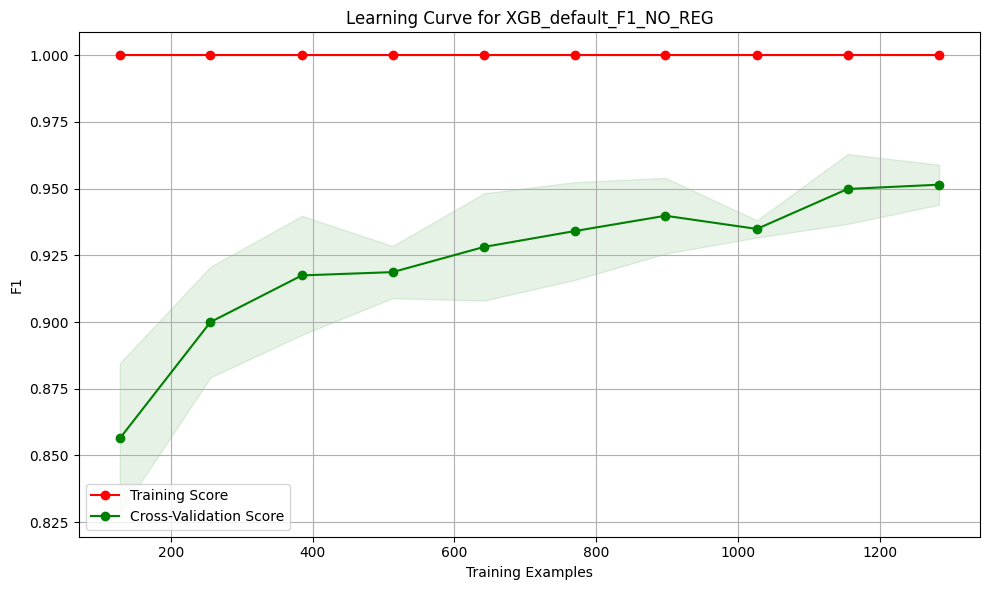

In [12]:
plot_learning_curve(xgb_default_no_reg, X_train, y_cancer_train, metric='f1', model_name='XGB_default_F1_NO_REG')

**Training Score (línea roja):**
- El score de entrenamiento es 1.0 en todo momento, lo que indica un sobreajuste muy significativo.

**Cross-Validation Score (línea verde):**
- La puntuación de validación comienza alrededor de 0.85 y mejora hasta ~0.93 con más ejemplos de entrenamiento.

**Diagnóstico:**
- Overfitting: Muestra un sobreajuste importante con una puntuación de entrenamiento de 1.0.
- Underfitting: No hay underfitting, ya que las puntuaciones de validación son altas.

**Conclusión inicial:**
- El modelo por defecto sin regularización también sufre de sobreajuste, aunque el rendimiento en validación es aceptable.

In [13]:
# Parámetros con regularización (modelo base) https://xgboost.readthedocs.io/en/stable/parameter.html  //  https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
params_default_reg = xgb_params_base.copy()
params_default_reg.update({
    'reg_alpha': 0.1,          # Regularización L1 (lasso)
    'reg_lambda': 1.0          # Regularización L2 (ridge)
})

xgb_default_reg = xgb.XGBClassifier(**params_default_reg)

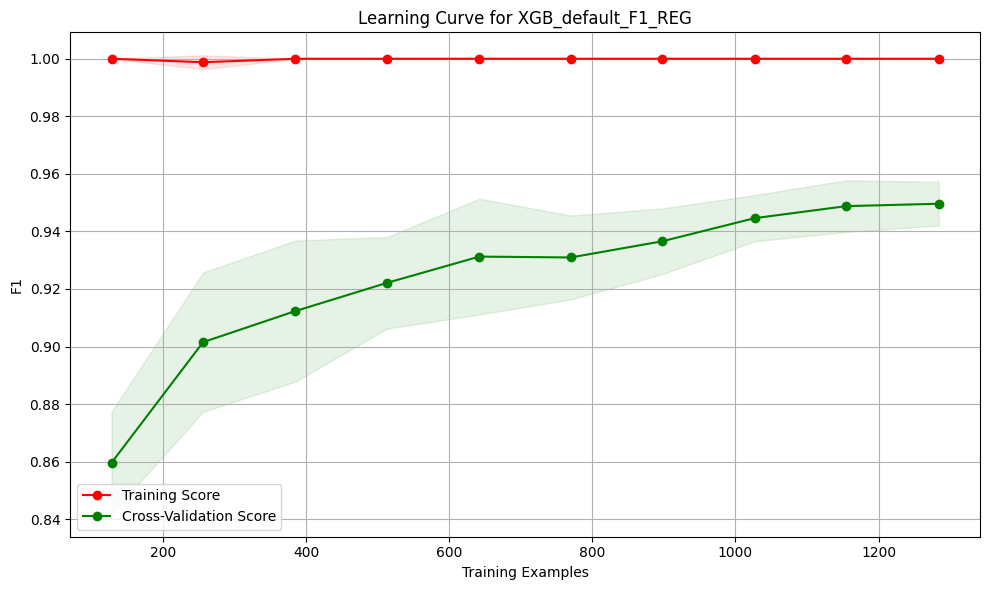

In [14]:
plot_learning_curve(xgb_default_reg, X_train, y_cancer_train, metric='f1', model_name='XGB_default_F1_REG')

**Training Score (línea roja):**
- La puntuación de entrenamiento sigue siendo alta (~1.0), aunque con una pequeña caída en algunos puntos.

**Cross-Validation Score (línea verde):**
- La puntuación de validación mejora de manera consistente, alcanzando ~0.93 con más ejemplos. Hay una menor variabilidad en el rendimiento comparado con la versión sin regularización.

**Diagnóstico:**
- Overfitting: Aunque el sobreajuste sigue siendo evidente, la regularización aplicada parece haber reducido la variabilidad y estabilizado el rendimiento del modelo en validación.
- Underfitting: No hay underfitting ya que el score de validación mejora con más datos.

**Conclusión inicial:**
La regularización ha ayudado a reducir ligeramente el sobreajuste y mejorar la estabilidad del modelo, aunque el sobreajuste sigue presente.

### 6.8.2. Random Search

In [15]:
# Configuración para utilizar GPU
xgb_params_base = {
    'objective': 'binary:logistic', # Clasificación binaria
    'eval_metric': 'logloss',       # Usar logloss para la métrica de evaluación
    'device': 'cuda',               # Utilizar la GPU
    'tree_method': 'hist',          # Utiliza la GPU para la construcción del histograma
    'random_state': 42              # Random number seed.
}

param_grid_xgb = {
    'n_estimators': [100, 200, 500], # Número de árboles
    'max_depth': [3, 5, 7, 9], # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.05, 0.1, 0.3], # Tasa de aprendizaje
    'subsample': [0.6, 0.8, 1.0], # Proporción de muestras usadas para entrenar cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0], # Fracción de características usadas para entrenar cada árbol
    'gamma': [0, 0.1, 0.5, 1], # Reducción mínima de la pérdida para hacer particiones
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10]
}

"""
# Configuración de GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(**xgb_params_base),
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1
    ) # En los otros métodos se ha usado cv=5


grid_xgb.fit(X_train, y_cancer_train)

# Mejor modelo XGB
xgb_best = grid_xgb.best_estimator_
print(f"Mejores hiperparámetros XGB: {grid_xgb.best_params_}")
"""

# Configuración de RandomizedSearchCV
random_xgb = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(**xgb_params_base),
    param_distributions=param_grid_xgb,
    n_iter=50,                            # Número de combinaciones a probar
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

# Ajustar el modelo
random_xgb.fit(X_train, y_cancer_train)

# Mejor modelo XGB
xgb_best = random_xgb.best_estimator_
print(f"Mejores hiperparámetros XGB: {random_xgb.best_params_}")

Mejores hiperparámetros XGB: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.8}


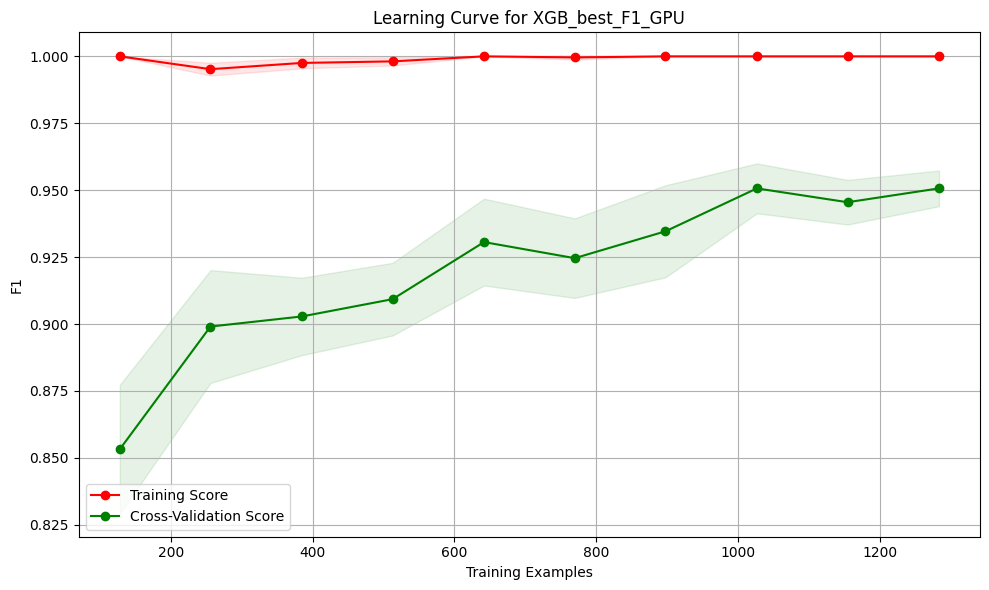

In [16]:
plot_learning_curve(xgb_best, X_train, y_cancer_train, metric='f1', model_name='XGB_best_F1_GPU')

**Training Score (línea roja):**
- El score de entrenamiento es consistentemente 1.0, lo que indica que el modelo está memorizando los datos, sugiriendo sobreajuste.

**Cross-Validation Score (línea verde):**
- La puntuación de validación comienza alrededor de 0.88 y mejora conforme aumenta el tamaño del conjunto de entrenamiento, alcanzando ~0.93 con más datos.

**Diagnóstico:**
- Overfitting: Existe sobreajuste claro, ya que la puntuación de entrenamiento es 1.0 mientras que la de validación es más baja (~0.93).
- Underfitting: No hay evidencia de underfitting, ya que las puntuaciones de validación son altas y mejoran con más datos.

**Conclusión inicial:**
- El modelo muestra sobreajuste considerable, pero el rendimiento en validación es aceptable.

In [17]:
# Guardar los mejores hiperparámetros
random_xgb_path = os.path.join(results_models_path, 'best_hyperparameters_xgb_gpu.txt')
with open(random_xgb_path, 'w') as f:
    f.write(f"Best hyperparameters XGB: {random_xgb.best_params_}\n")

In [18]:
# Guardar modelo
joblib.dump(xgb_best, os.path.join(results_models_path, 'best_model_xgb.pkl'))

['/content/drive/My Drive/results/models/best_model_xgb.pkl']

**Conclusiones generales**

**Overfitting:**
- Todos los modelos optimizados y por defecto muestran cierto nivel de sobreajuste, con puntuaciones de entrenamiento consistentemente más altas que las de validación. Los modelos MLP y XGBoost optimizados son particularmente propensos a sobreajustarse.

**Regularización:**
La regularización aplicada en XGBoost ayudó a reducir ligeramente el sobreajuste, pero no fue suficiente para eliminarlo por completo.

**Próximos Pasos:**
- Regularización más fuerte: Aumentar los valores de regularización (reg_alpha, reg_lambda) podría reducir aún más el sobreajuste.
- Técnicas de reducción de dimensionalidad: Aplicar técnicas como PCA o selección de características adicionales podría ayudar a reducir la complejidad del modelo y mejorar su generalización.
- Modelos más robustos: Explorar modelos adicionales, como Ensemble Methods o redes neuronales más profundas con dropout y regularización L2, podría ofrecer mejoras.

### 6.8.3. Custom

In [19]:
xgb_params_custom = {
    'objective': 'binary:logistic', # Clasificación binaria
    'eval_metric': 'logloss',       # Usar logloss para la métrica de evaluación
    'device': 'cuda',               # Utilizar la GPU
    'tree_method': 'hist',          # Utiliza la GPU para la construcción del histograma
    'random_state': 42,             # Random number seed.
    'reg_alpha': 2,               # Regularización L1 (lasso) -> Se aumenta la regularización (entre 0 y 10)
    'reg_lambda': 5,              # Regularización L2 (ridge) -> Se aumenta la regularización (entre 0 y 100)
    'subsample': 0.6,               # Parámetros optimizados
    'n_estimators': 100,
    'max_depth': 7,
    'learning_rate': 0.3,
    'gamma': 0,
    'colsample_bytree': 0.8
}

xgb_custom1 = xgb.XGBClassifier(**xgb_params_custom)

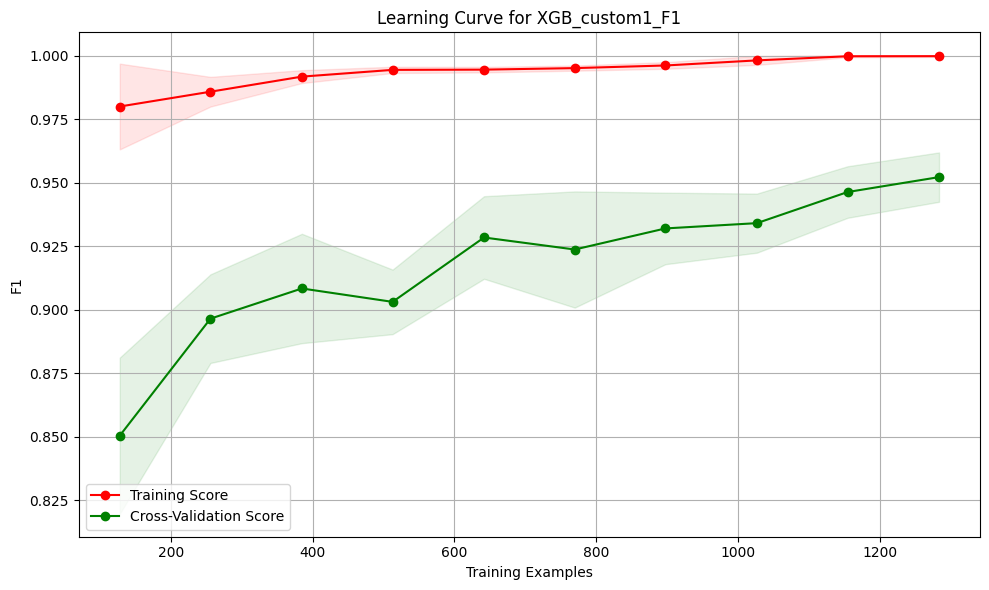

In [20]:
plot_learning_curve(xgb_custom1, X_train, y_cancer_train, metric='f1', model_name='XGB_custom1_F1')

In [21]:
# Guardar modelo
xgb_custom1.fit(X_train, y_cancer_train)
joblib.dump(xgb_custom1, os.path.join(results_models_path, 'custom1_model_xgb.pkl'))

['/content/drive/My Drive/results/models/custom1_model_xgb.pkl']

In [22]:
xgb_params_custom = {
    'objective': 'binary:logistic', # Clasificación binaria
    'eval_metric': 'logloss',       # Usar logloss para la métrica de evaluación
    'device': 'cuda',               # Utilizar la GPU
    'tree_method': 'hist',          # Utiliza la GPU para la construcción del histograma
    'random_state': 42,             # Random number seed.
    'reg_alpha': 2,                 # Regularización L1 (lasso) -> Se aumenta la regularización (entre 0 y 10)
    'reg_lambda': 5,                # Regularización L2 (ridge) -> Se aumenta la regularización (entre 0 y 100)
    'subsample': 0.8,               # Se aumenta el valor para utilizar mas datos para construir cada arbol
    'n_estimators': 300,            # Se aumentan los n_estimators porque se ha reducido el learning rate
    'max_depth': 5,                 # Reducimos el valor. Los árboles más profundos capturan patrones más complejos
    'learning_rate': 0.1,           # Se reduce porque de esta manera el modelo se entrena más poco a poco
    'gamma': 0.1,
    'colsample_bytree': 0.8
}

xgb_custom2 = xgb.XGBClassifier(**xgb_params_custom)

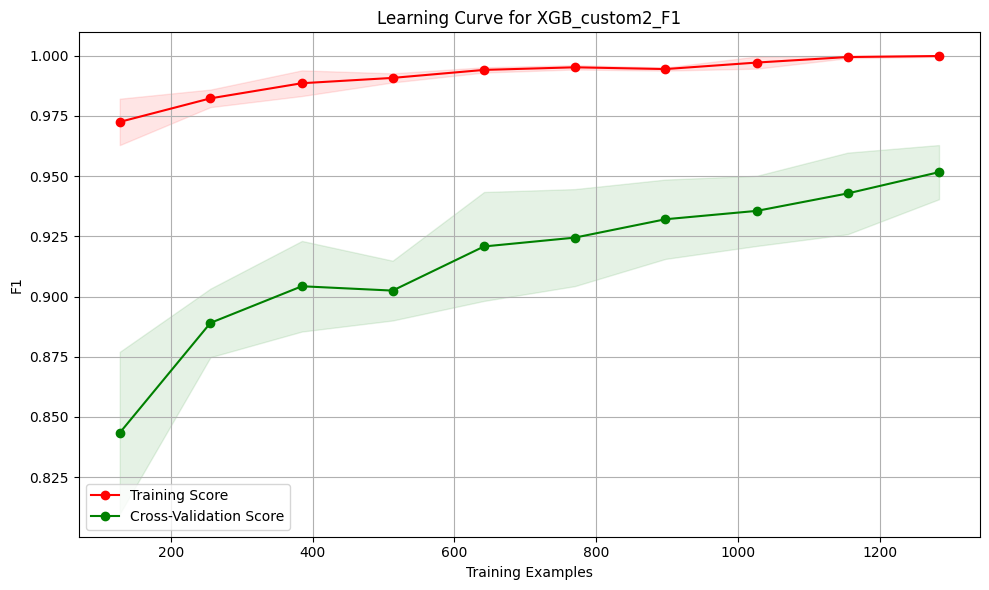

In [23]:
plot_learning_curve(xgb_custom2, X_train, y_cancer_train, metric='f1', model_name='XGB_custom2_F1')

In [24]:
# Guardar modelo
xgb_custom2.fit(X_train, y_cancer_train)
joblib.dump(xgb_custom2, os.path.join(results_models_path, 'custom2_model_xgb.pkl'))

['/content/drive/My Drive/results/models/custom2_model_xgb.pkl']

# Evaluación

In [29]:
def evaluate_model(model, X_test, y_test):
    """
    Evalúa el modelo seleccionado y genera métricas de evaluación y visualización.

    Parametros:
    - model: Modelo previamente entrenado
    - X_test: Características del conjunto de prueba
    - y_test: Etiquetas del conjunto de prueba
    """

    # Realizar predicciones con el modelo seleccionado
    y_pred = model.predict(X_test)

    # Probabilidades de predicción para la curva ROC
    y_proba = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad para la clase positiva (1)

    # Calcular las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)

    # Mostrar las métricas de evaluación
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'AUC-ROC: {auc_roc:.4f}')

    # Mostrar el reporte de clasificación
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Generar la matriz de confusión
    model_name = model.__class__.__name__
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Valor predicho')
    plt.ylabel('Valor real')
    plt.title(f'Matriz de Confusión {model_name}')
    plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:09:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9410
Precision: 0.8522
Recall: 0.9899
F1-Score: 0.9159
AUC-ROC: 0.9775

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       206
           1       0.85      0.99      0.92        99

    accuracy                           0.94       305
   macro avg       0.92      0.95      0.94       305
weighted avg       0.95      0.94      0.94       305



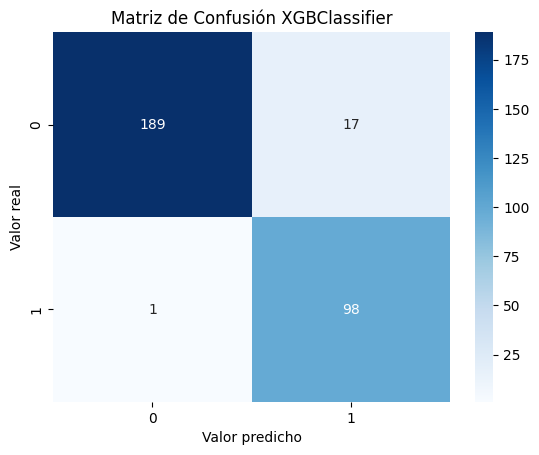

In [30]:
evaluate_model(xgb_custom2, X_test, y_cancer_test)

In [31]:
from sklearn.metrics import roc_curve, auc

def plot_roc_pr_curves(model, X_test, y_test):
    """
    Genera las curvas ROC y Precision-Recall para el modelo seleccionado.

    Parametros:
    - model: Modelo previamente entrenado
    - X_test: Características del conjunto de prueba
    - y_test: Etiquetas del conjunto de prueba
    """
    # Obtener probabilidades de predicción para la clase positiva
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad para la clase positiva (1)

    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)  # Área bajo la curva ROC (AUC)

    # Calcular la curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)  # Área bajo la curva PR (Average Precision Score)

    model_name = model.__class__.__name__

    # Plot de la curva ROC
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, gráfico 1
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal para referencia
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC {model_name}')
    plt.legend(loc='lower right')

    # Plot de la curva Precision-Recall
    plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, gráfico 2
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curva Precision-Recall {model_name}')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()


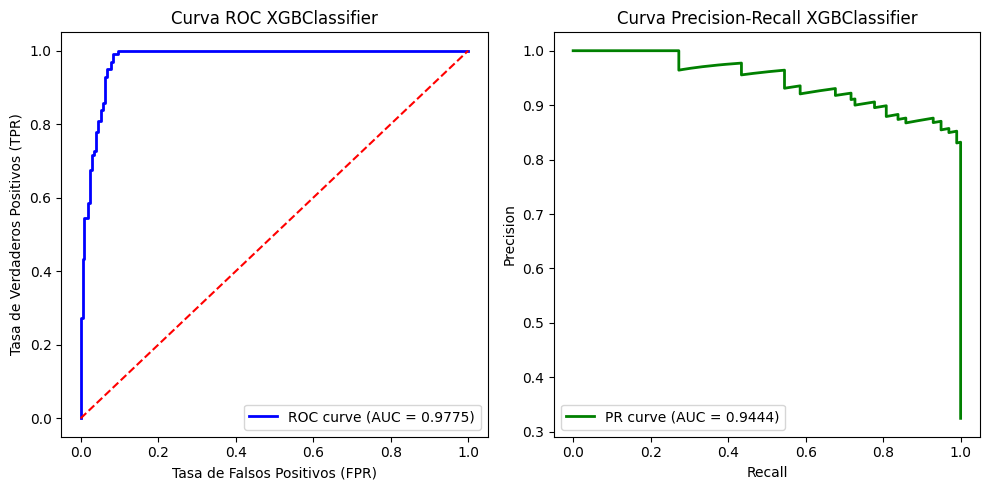

In [33]:
plot_roc_pr_curves(xgb_custom2, X_test, y_cancer_test)

# Características

In [34]:
def feature_importance(model, X_train):
    """
    Grafica la importancia de las características para Random Forest y XGBoost.

    Parametros:
    - model: Modelo previamente entrenado (RandomForest o XGBoost).
    - X_train: Características del conjunto de prueba

    Devoluciones:
    - feature_importance_df: DataFrame con nombres de características y sus valores de importancia
    """
    #Nombres de caracteristicas
    feature_names = X_train.columns

    # Obtener la importancia de las características
    importances = model.feature_importances_

    # Crear un DataFrame con nombres de características e importancia
    feature_importance_df = pd.DataFrame({
        'miARN': feature_names,
        'Importancia': importances
    })

    # Ordenar por importancia
    feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
    feature_importance_df.reset_index(inplace=True, drop=True)

    # Ordenar la importancia de las características y seleccionar las top más importantes
    indices = np.argsort(importances)[::-1]

    # Graficar la importancia de las características
    model_name = model.__class__.__name__
    plt.figure(figsize=(30, 6))
    plt.title(f'Importancia de las Características - {model_name}')
    plt.bar(range(len(feature_names)), importances[indices], align='center')
    plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
    plt.xlabel('miRNAs')
    plt.ylabel('Importancia')
    plt.grid(True)
    plt.show()

    return feature_importance_df


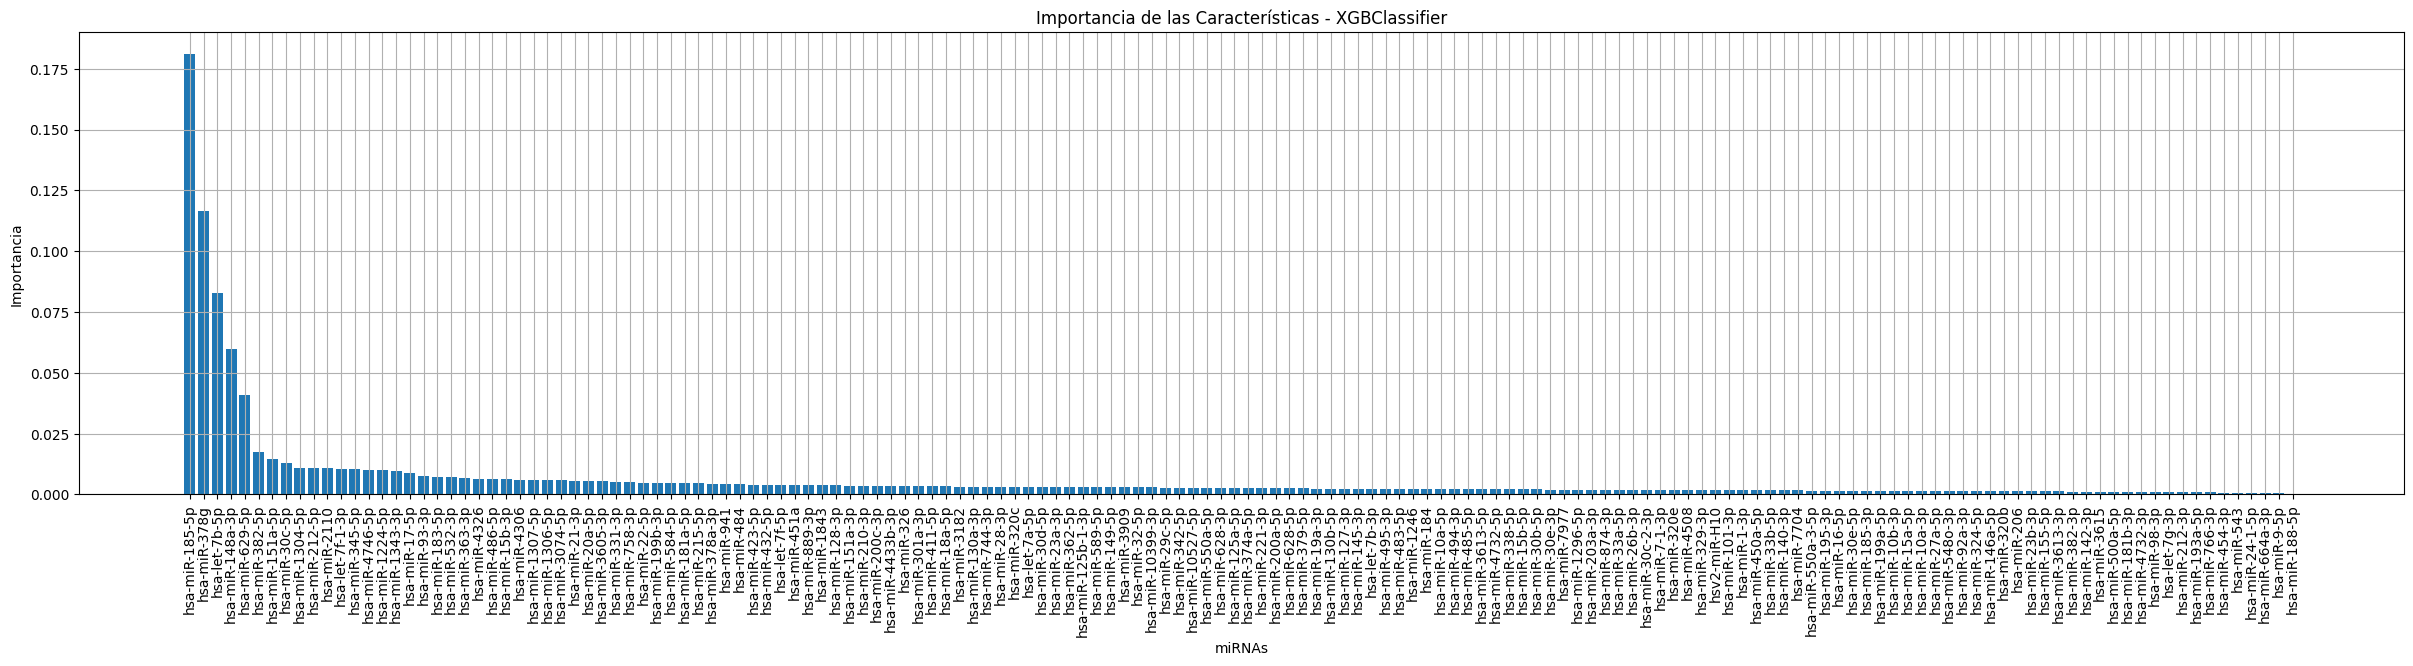

In [39]:
characteristics_path = os.path.join(base_dir, 'results/characteristics')
xgb_feature_importance_df = feature_importance(xgb_custom2, X_train)
# Guardar el csv
xgb_feature_importance_path = os.path.join(characteristics_path, 'xgb_feature_importance.csv')
xgb_feature_importance_df.to_csv(xgb_feature_importance_path, index=False)